<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 70px">

## Notebook 2: EDA & Modelling

#### Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import capstone_library as cl

# Instead of Keras/Tensorflow, we will be using Pytorch for modelling. The Pytorch library was installed with CUDA, for GPU processing.
# You may refer to this link for a guide on how to install Pytorch with CUDA: https://pytorch.org/get-started/locally/
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
# Setting device to 'cuda'. Tensors and models mapped to this device will be processed with the GPU instead of the CPU.
device = 'cuda'

## 2.1 Data Cleaning
___

#### Defining directories
After the data collection step, the images and dataframes are stored in seperate directories, filed by date. Images and dataframes to be used for modelling are copied into the following directories below. The `datadict` fucntion will read from these directories to retrieve the images and dataframes to be used for EDA and modelling.

In [2]:
imgpath = '../data/raw_img/_for_model/'
csvpath = '../data/input/_for_model/'

### The `datadict` function
___
After placing the collected data into the above directories, we will have the following set of data:
- Images named by timestamp, in seperate folders sorted by the opponent Pokemon detected.
- Multiple dataframes in a single folder, each dataframe with the following information:

| Feature | Datatype | Details |
|----|---|-|
| time | str | Datetime in YY-MM-DD, followed by hour-min-sec-ms |
| opp | str | Name of opponent Pokemon in corresponding image |
| SPACEBAR | int | 1/0 boolean indicating if the spacebar is pressed |
| a | int | 1/0 boolean indicating if the 'a' key is pressed |
| s | int | 1/0 boolean indicating if the 's' key is pressed |
| d | int | 1/0 boolean indicating if the 's' key is pressed |
| j | int | 1/0 boolean indicating if the 'j' key is pressed |
| k | int | 1/0 boolean indicating if the 'k' key is pressed |
| l | int | 1/0 boolean indicating if the 'l' key is pressed |

We will process these images and dataframes to create a data dictionary, where the images and input dataframes can be sorted by the respective opponent Pokemon.

A visualisation for the structure of our data dictionary is depicted below:

- `data_dict:`
    - `poliwrath:`
        - `images:` list of `poliwrath` images in array format
        - `inputs:` input dataframe for `poliwrath`
    - `heracross:`
        - `images:` list of `heracross` images in array format
        - `inputs:` input dataframe for `heracross`
    - `mienshao:`
        - `images:` list of `mienshao` images in array format
        - `inputs:` input dataframe for `mienshao`

The cleaning and processing of the data into our data dictionary will be performed by the `datadict` function. We summarise the cleaning and processing steps below.

As part of the model refinement process, the data cleaning process has been iteratively updated to improve the predictive ability of the model. The changes are highlighted by asterisks below and are explained in futher detail in the _Additional Steps_ section.

#### Steps in `datadict` function

1. **Reading dataframes from the folder directory**

    First, read the dataframe .csv files from the specified directory. All dataframes are then concatenated vertically into a single dataframe.

2. <b>Engineering the `isattack` feature in the dataframe*</b>

3. **Reading images and filtering dataframe by Pokemon**

    Using a 'for' loop to go through each Pokemon specified in the function call, we filter the concatenated dataframe by Pokemon based on the `opp` column. Then, we navigate to the directory for images of the specified Pokemon. All images in the directory are read into Python as a list of arrays.
    - When reading the image, we crop out the top 50 pixels to omit the HP bars<b>**</b>. Further details in additional steps below.

4. **Perform Check 1**

    Within the same 'for' loop, we perform Check 1: if there are rows in 'input' with missing corresponding images, filter out such rows from the dataframe. This is done by comparing the file names with the `time` column in the dataframe.

5. <b>Filter out rows with no inputs***.</b>

6. **Perform Check 2**

    We then perform Check 2: if there are remaining images with no corresponding rows. This situation is potentially symptomatic of an issue during the data collection process, which may lead to mismatch of input rows and images. If this check is 'True', the function raises a flag to recheck data and does not output a dictionary.
    - Note: If Check 2 is raised after adding a new batch of data, the function can be rerun with no further issues.

7. **Delete unused images from the image directory and remove `opp` and `time` columns from input dataframe.** 

8. **Insert dataframe and image list to the dictionary**

    At the end of the 'for' loop, insert the dataframe to the data dictionary entry for the Pokemon using the `inputs` key, then similarly insert the list of image arrays using the `images` key.

8. **Return data dictionary (if Check 2 passed).**

#### Additional Steps

<b>_*Engineering an_ `isattack` _feature_</b>

After an initial round of EDA and modelling, the model was found to perform poorly in terms of executing attacks. This is attributed to the imbalanced nature of our input data, where the 'True' state for our target variables (the keys being pressed) are each sparsely distributed in the dataset (refer to EDA step further below.) 

To improve the model's predictive ability for performing attacks, a new feature is engineered during the data cleaning step, `isattack`. This feature is a boolean 1/0 value similar to the keypress features, but is instead set to 1 if a keypress is present in any of the 3 attack inputs (`j`, `k`, or `l`) , and 0 when no keypresses are detected in any of the attack inputs.

<b>_**Cropping out HP bars_</b>

One attempt to improve the model's performance was to introduce rows with images flipped horizontally. However, one concern with this proposal is the HP bars at the top of the screen, which will take on different meanings when flipped horizontally. To avoid this potential issue, the data cleaning steps were modified to include a cropping step, which removes the top 50 pixels of each image to omit the HP bars.

Refer to the image below for a visualisation of the area being cropped from our images (the area squared out in red).

<img src="images/hp_crop.png"/>

Further details on the image flipping can be found in the _EDA_ section under the `flipall` function.

<b>_***Filtering out rows with no inputs_</b>

The first model performed poorly in general, with prediction values often being closer to 0 (using a sigmoid output, 1 would indicate a True and vice versa). Further EDA showed that a noticeable proportion of readings had no input recorded. Often times this was due to intermediate scenes between matches (the win/lose screen) and getting stuck in an opponent's combo, among other scenarios which warranted minimal input. These rows of data have adverse effects on the model as they further skew the imbalance of the classes within the target features.

Thus, we shall drop all rows with no inputs during the data cleaning step.

In [3]:
def datadict(imgpath, csvpath, mon_list):
    # Initialise data dictionary
    data_dict = {}

    # Concat all csvs in the defined path into the 'inputs' dataframe
    csv_names = [file for file in os.listdir(csvpath) if file.endswith('.csv')]
    inputs = pd.concat([pd.read_csv(csvpath + file) for file in csv_names], ignore_index=True)

    # Data engineering: adding a 'isattack' feature
    inputs['isattack'] = (~(inputs[['j','k','l']]==0).all(axis=1)).astype(int)

    # Fill up data dictionary with for loop:
    checkstate = 0
    for mon in mon_list:
        data_dict[mon] = {}
        fullpath = imgpath + mon + '/'

        # Filter the 'inputs' dataframe to the specific mon
        input_df = inputs[inputs['opp']==mon].reset_index(drop=True)

        # For each mon, write all images (as a list of arrays)
        # When reading, crop out the top 50 pixels to remove the HP bars.
        img_names = [pic for pic in os.listdir(fullpath) if pic.endswith('.png')]
        images = [cv.imread(fullpath + pic)[50:,:] for pic in img_names]

        # Check 1: if there are remaining rows in 'input' with missing corresponding images, filter out such rows
        img_index = pd.DataFrame([img[:-4] for img in img_names], columns=['time'])
        check1 = pd.merge(input_df, img_index, how='inner', on='time')
        if len(check1) < len(input_df):
            print('{} rows of inputs for {} were removed as their corresponding image was missing.'.format((len(input_df) - len(check1)), mon))
            input_df = check1.reset_index(drop=True)

        # Rows with no inputs are bad for the model. Drop these rows and their corresponding images
        filter = (input_df[cl.controls]==0).all(axis=1)
        emptyrows = input_df.index[filter]
        deletelist = []
        for index in sorted(emptyrows, reverse=True):
            images.pop(index)
            deletelist.append(img_names[index])
            img_names.pop(index)
        input_df = input_df[~filter].reset_index(drop=True)
        if len(emptyrows):
            print('{} rows for {} had no inputs and were dropped.'.format(len(emptyrows), mon))
        
        # Check 2: if there are remaining images with no corresponding rows, set checkstate to 1 (indicates check failed)
        check2 = pd.merge(input_df, img_index, how='outer', on='time')
        if check2.isna().sum().sum():
            print('There are images for {} with no corresponding input. Please recheck data or rerun function.'.format(mon))
            checkstate = 1

        # Remove unused images from img directory
        for pic in deletelist:
            os.remove(fullpath + pic)
        if len(deletelist):
            print('{} images were deleted from the {} directory'.format(len(deletelist), mon))

        # After running checks, drop the 'time' and 'opp' columns in the 'inputs' dataframe
        # Append 'inputs' and 'images' to each pokemon's dictionary entry
        data_dict[mon]['inputs'] = input_df.drop(columns=['time','opp'])
        data_dict[mon]['images'] = images
        print()
    
    # After for loop is completed, if check 2 failed, give an error printout and return nothing. Else, return data_dict
    if checkstate:
        print('\nNo output given.')
        return None
    else:
        for mon in mon_list:
            print('{} created with {} entries.'.format(mon, len(data_dict[mon]['inputs'])))
        print('\ndata_dict has been successfully created.')
        return data_dict

#### The `display_examples` function

This function retrieves 10 random rows from the specified Pokemon's dictonary, then prints the keyboard input and the corresponding image for the row. This function is used to quickly compare the images and their corresponding inputs, to identify any issues of mislabelled data from the `datadict` function.

In [4]:
'''
Function to check images in dataset and the corresponding input
'''
def display_examples(dict, mon):
    images = dict[mon]['images']
    inputs = dict[mon]['inputs'].to_numpy()
    fig = plt.figure(figsize=(15,10))
    fig.suptitle("Some examples of images in the dataset", fontsize=16)
    for i in range(10):
        random = np.random.choice(len(images))
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cv.cvtColor(images[random], cv.COLOR_BGR2RGB), cmap=plt.cm.binary)
        plt.xlabel(cl.translate(inputs[random]))
    plt.show()

#### Running the functions

We run the `datadict` function below to create our data dictionary named `data_dict`.

In [5]:
data_dict = datadict(imgpath, csvpath, ['poliwrath', 'heracross', 'mienshao'])

508 rows of inputs for poliwrath were removed as their corresponding image was missing.

589 rows of inputs for heracross were removed as their corresponding image was missing.

484 rows of inputs for mienshao were removed as their corresponding image was missing.

poliwrath created with 1285 entries.
heracross created with 1504 entries.
mienshao created with 1033 entries.

data_dict has been successfully created.


Here we run the `display_examples` function to compare randomly selected images with their corresponding inputs.

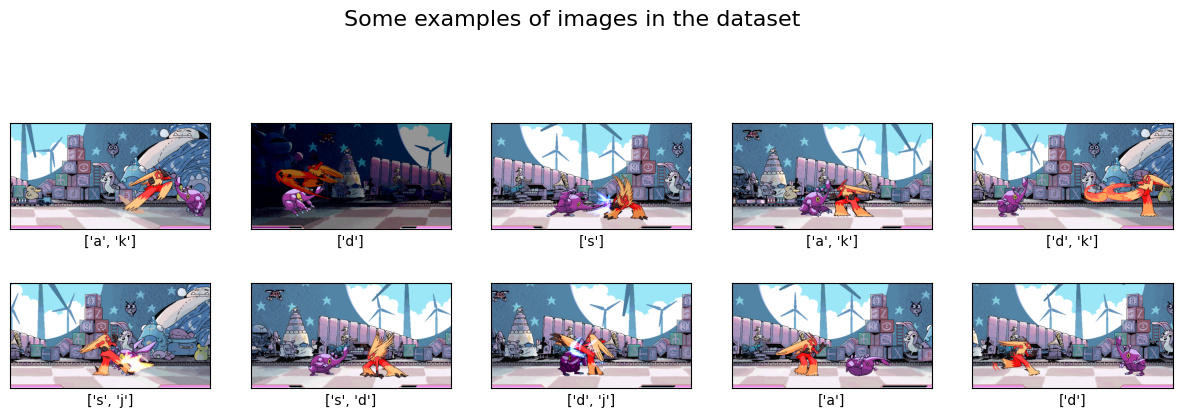

In [6]:
display_examples(data_dict, 'heracross')

## 2.2 EDA & Data Engineering
___

After the data cleaning steps, we shall perform some EDA on the data. We will want to determine the following:

- The proportion of inputs recorded with attacks (the `isattack` column):

    In the context of the game, we will want to have a higher recall for performing attacks. Comparing the proportions of inputs with and without attacks will help us determine if further engineering is needed to increase the proportion of attacking inputs.

- The proportion of inputs recorded with directional inputs:

    Similar to the above but for directional inputs instead of attack inputs (`SPACEBAR`, `a`, `s`, `d`). 

- Number of rows with confliting directions:

     We want to avoid conflicting inputs as much as possible as they may have adverse effects on the predictive ability of the model. Identifying the number of rows with such conflicting inputs will help us determine if the number of rows is low enough for us to drop with no issue.

     Note that when attack inputs conflict, the game performs an attack by priority (normal attack `j` with the most priority, and grab/parry `l` with the least priority). Thus, there is less necessity to drop rows with conflicting attacks.

- General understanding of the distribution of data:

    As we are dealing with multiple boolean data, we can display their distribution on a single count plot to compare their relative distributions with each other.
    

We will use the `eda` function below to generate this information.

In [7]:
def eda(mon):
    df = data_dict[mon]['inputs']

    # filter_dir: filters dataframe to rows where no directional inputs ['SPACEBAR', 'a', 's', 'd'] are recorded
    filter_dir = (df[cl.d_controls]==0).all(axis=1)

    # filter_conf: filters dataframe to rows where where the left and right directions ['a', 'd'] OR jump and crouch ['SPACEBAR', 's'] are conflicting
    filter_conf = (df[['a', 'd']]==1).all(axis=1) | (df[['SPACEBAR', 's']]==1).all(axis=1)

    print('{}:\nOut of {} rows, {} were recorded with attacks ({:.2f}%).'.format(mon, len(df), len(df[df['isattack']==1]), len(df[df['isattack']==1])/len(df)*100))
    print('{} rows were recorded with directional inputs ({:.2f}%).'.format(len(df[~filter_dir]), len(df[~filter_dir])/len(df)*100))
    print('{} rows were recorded with conflicting directions ({:.2f}%).\n'.format(len(df[filter_conf]), len(df[filter_conf])/len(df)*100))
    sns.countplot( x="variable", hue="value", data=pd.melt(df)).set_title('Spread of inputs for {}'.format(mon))

poliwrath:
Out of 1285 rows, 287 were recorded with attacks (22.33%).
1218 rows were recorded with directional inputs (94.79%).
14 rows were recorded with conflicting directions (1.09%).



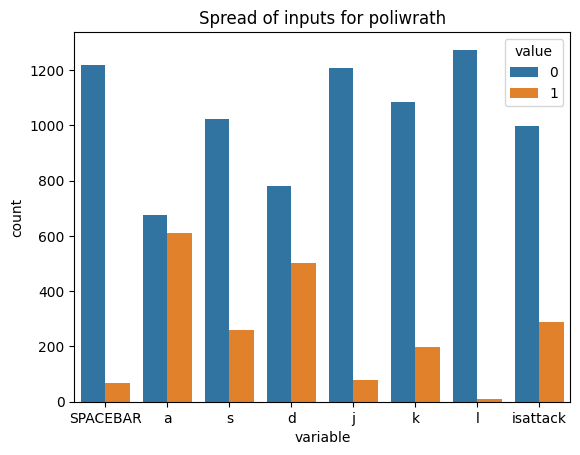

In [8]:
eda('poliwrath')

heracross:
Out of 1504 rows, 368 were recorded with attacks (24.47%).
1403 rows were recorded with directional inputs (93.28%).
14 rows were recorded with conflicting directions (0.93%).



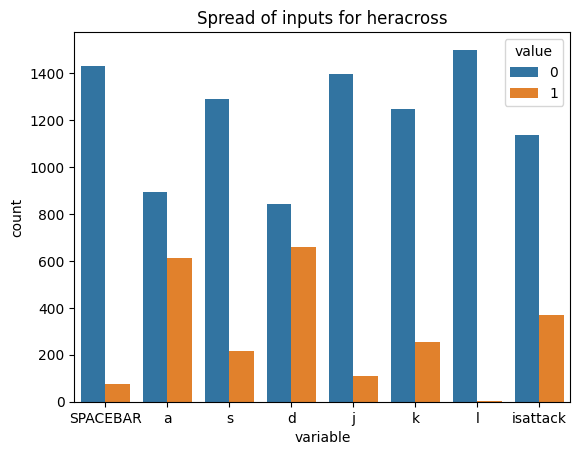

In [9]:
eda('heracross')

mienshao:
Out of 1033 rows, 295 were recorded with attacks (28.56%).
960 rows were recorded with directional inputs (92.93%).
12 rows were recorded with conflicting directions (1.16%).



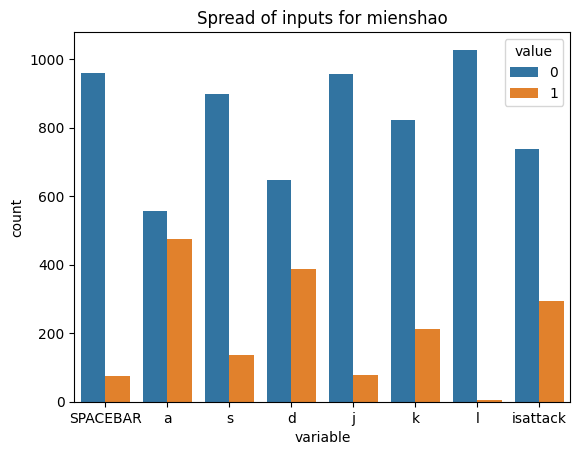

In [10]:
eda('mienshao')

After performing EDA, we notice these trends in the 3 different groups of data:

- Rows with attck inputs (`isattack` true) typically only account for 20-30% of the data.

- Majority of rows have at least 1 directional input, more than 90% for all 3 sets of data.

- Very few rows with conflicting directional inputs (less than 2% of all rows). We can drop these rows with no issues.

- Between the 3 attack inputs, `k` is the most frequent, followed by `j`. Very little inputs are recorded for `l` (`heracross` in particular has only 4 recorded inputs).

- `SPACEBAR` and `s` inputs (jump and crouch) are less typically less frequent than the `a` and `d` inputs (left and right).

#### Data engineering functions
Based on the above observations, we will perform data engineering using the functions below.

- `dropconf`: Drop all rows and images with conflicting directions.

In [11]:
def dropconf(mon):
    # First drop all rows with conflicting directions
    df = data_dict[mon]['inputs']
    filter_conf = (df[['a', 'd']]==1).all(axis=1) | (df[['SPACEBAR', 's']]==1).all(axis=1)

    # Use the index of the conflicting rows to drop their corresponding images
    droprows = df.index[filter_conf]
    for index in sorted(droprows, reverse=True):
        data_dict[mon]['images'].pop(index)
    df = df[~filter_conf].reset_index(drop=True)

    data_dict[mon]['inputs'] = df
    print('Rows with conflicting directions were dropped, remaining data for {} with {} rows.\n'
          .format(mon, len(df)))

- `dropnoatt`: Drop a proportion of rows and images with no attacks, based on the proportion specified during the function call (`dropamt`). This step is performed to improve the recall for attack performance; we want the model to predict as many attacks as possible, because more attacks = more damage = higher chance of winning. The rows and images to be dropped are randomly sampled from the full set of rows with no attacks, using the `.sample` function.

    The function was designed to allow for varying drop proportions, to accomodate for the variations in data distribution for the 3 Pokemon.


In [12]:
def dropnoatt(mon, dropamt):
    df = data_dict[mon]['inputs']

    # dropindex: index of rows to be dropped. Obtained by using .sample to randomly select rows following the filter condition
    dropindex = sorted(df[df['isattack']==0].sample(frac=dropamt, random_state=143).index, reverse=True)

    # Use dropindex to drop the appropriate rows from the dataframe
    df = df.drop(dropindex)

    # Use dropindex to drop the corresponding images
    for index in dropindex:
        data_dict[mon]['images'].pop(index)

    data_dict[mon]['inputs'] = df.reset_index(drop=True)
    print('{:.2f}% of rows with no attacks were dropped.\nOut of {} remaining rows, {} were recorded with attacks.\n'
            .format(dropamt*100, len(df),  len(df[df['isattack']==1])))

- `bootstrap`: A specified input type is bootstraped by a mulitple defined during the function call (eg. default `multiple`=2 will double the number of rows for the specified input).

    We will primarily be using this for two inputs: `j` and `l`. These inputs correspond to the normal attack and grab/parry. In the context of the game, these inputs should generally only be performed when the opponent is within range, as whiffing an attack will leave the character vulnerable to an opponent's attack. This is especially true for grabs, which are highly effective only at close range. Compare these to the special attack button `k`, which sees higher frequency of input. This is because special attacks generally have higher effective ranges and can used at varying ranges from the opponent.
    
    Nonetheless, we want the model to learn to utilise normal attacks and grabs when at the appropriate range. Thus, we will bootstrap rows with these inputs to improve the model's confidence in predicting them. 
    
    Note that rows with `l` input will see a significant amount of bootstrapping (for `heracross` in particular, `l` inputs were bootstrapped by a multiple of 15). Although there is a concern for overfitting by doing so, iterative modelling and remodelling shows that the bootstrapping results in noticeable improvement for performing successful grabbing attacks, thus justifying the larger bootstrapping amount.

In [13]:
def bootstrap(mon, input, multiple=2):
    df = data_dict[mon]['inputs']

    # filter_inp: filter for only rows where the input of interest is recorded
    filter_inp = (df[input]==1)
    # inpindex: index of rows where the input of interest is recorded
    inpindex = df[filter_inp].index

    # Append images and concatenate rows for the bootstrapped data, based on the value passed in multiple
    # Eg: multiple of 3 would append the bootstrapped rows (3-1) times, thus tripling the data being bootstrapped
    for _ in range(multiple-1):
        for index in inpindex:
            data_dict[mon]['images'].append(data_dict[mon]['images'][index])
        df2 = pd.concat([data_dict[mon]['inputs'], df[filter_inp]], ignore_index=True).reset_index(drop=True)
        data_dict[mon]['inputs'] = df2
    
    print("For {}, rows with '{}' input were bootstrapped from {} to {} rows.\n"
          .format(mon, input, len(inpindex), len(data_dict[mon]['inputs'][(data_dict[mon]['inputs'][input]==1)])))

- `flipall`: Flip each image horizontally and append the flipped images to the end of the existing image list. For the input dataframe, copy the dataframe, inverse the copy's left and right inputs (`a` and `d`) and concatenate the copy to the end of the dataframe. This effectively doubles the number of rows and images.

    After testing a few models, there was a noticeable difference in behaviour for the bot character that was dependent on its position on the screen. For example, the bot was more likely to perform jumps when on the right, and more likely to use fireballs on the left. To mitigate this issue, we apply the concept of image distortion on our data, in this case introducing rows where the existing images are horizontally. This allows the model to predict the same actions regardless of its screen position. Note that for our distorted images, the left and right inputs corresponding to the image will also need to be flipped to account for the distortion.

    This data engineering step provides the following benefits:

    - Generalises predictions instead of overfitting based on screen position.
    
    - Doubles training data, giving the model better predictive power and generalisability.
    
    - Inversion of background elements (eg. Pokemon or people standing in the background) will condition the model to ignore these elements when performing predictions, and focus on the main battle scene instead.

    This step was previously omitted due to the presence of HP bars, which would confer different implications when flipped horizontally. The initial models were fed images which included the HP bar and did not go through the image distortion step, as we wanted to determine the effectiveness of prediction based on information from the HP bar (for example, a character with lower HP should play more defensively to avoid losing the round, while a character with higher HP should act more aggressively to close the round).

    However, these older models displayed the above problem of overfitting on screen position. Here the decision was made to explore the introduction the horizontally flipped rows, and to omit the HP bar from our input images to avoid the distortion of information when flipping the HP bars. Ultimately, in spite of the loss of HP bar infomation, the model proved to generalise and perform better in matches after the flipping process, justifying the addition of this step for our final model. The cropping of the HP bars also had an additional benefit of reducing the final model size by about 10%, as less image information is fed to the model for prediction.

In [14]:
def flipall(mon):
    # Flip left and right inputs ['a', 'd'] and append to the bottom of the dataframe
    flipdf = data_dict[mon]['inputs'].copy()
    flipdf[['a', 'd']] = (~flipdf[['a', 'd']].astype(bool)).astype(int)
    newdf = pd.concat([data_dict[mon]['inputs'], flipdf], ignore_index=True).reset_index(drop=True)
    data_dict[mon]['inputs'] = newdf

    # Flip all images and append to end of the image list
    for index in range(len(data_dict[mon]['images'])):
        data_dict[mon]['images'].append(cv.flip(data_dict[mon]['images'][index], 1))

    print('Datapoints for {} were doubled by flipping existing data horizontally. Final number of rows: {}'.format(mon, len(newdf)))

#### Running the data engineering functions

We run the above data engineering functions for each Pokemon's data below.

In [15]:
dropconf('poliwrath')
bootstrap('poliwrath', 'j')
bootstrap('poliwrath', 'l', multiple=6)
dropnoatt('poliwrath', 0.6)
flipall('poliwrath')
sns.countplot(x="variable", hue="value", data=pd.melt(data_dict['poliwrath']['inputs'])).set_title('Spread of inputs for {} after engineering'.format('poliwrath'))

Rows with conflicting directions were dropped, remaining data for poliwrath with 1271 rows.

For poliwrath, rows with 'j' input were bootstrapped from 78 to 156 rows.

For poliwrath, rows with 'l' input were bootstrapped from 11 to 66 rows.

60.00% of rows with no attacks were dropped.
Out of 813 remaining rows, 419 were recorded with attacks.
Datapoints for poliwrath were doubled by flipping existing data horizontally. Final number of rows: 1626


Rows with conflicting directions were dropped, remaining data for heracross with 1490 rows.

For heracross, rows with 'j' input were bootstrapped from 109 to 218 rows.

For heracross, rows with 'l' input were bootstrapped from 4 to 60 rows.

55.00% of rows with no attacks were dropped.
Out of 1037 remaining rows, 532 were recorded with attacks.
Datapoints for heracross were doubled by flipping existing data horizontally. Final number of rows: 2074


Text(0.5, 1.0, 'Spread of inputs for heracross after engineering')

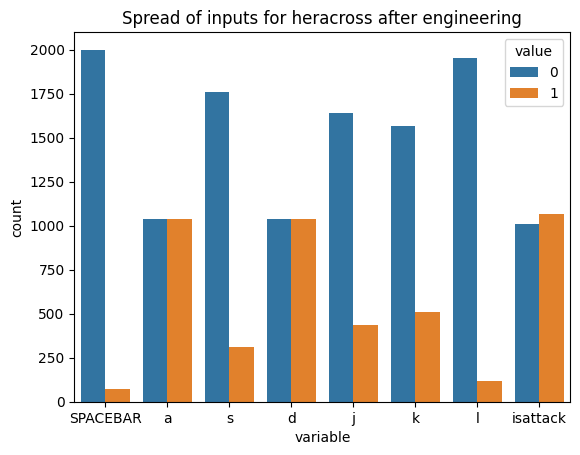

In [16]:
dropconf('heracross')
bootstrap('heracross', 'j')
bootstrap('heracross', 'l', multiple=15)
dropnoatt('heracross', 0.55)
flipall('heracross')
sns.countplot(x="variable", hue="value", data=pd.melt(data_dict['heracross']['inputs'])).set_title('Spread of inputs for {} after engineering'.format('heracross'))

Rows with conflicting directions were dropped, remaining data for mienshao with 1021 rows.

For mienshao, rows with 'j' input were bootstrapped from 78 to 156 rows.

For mienshao, rows with 'l' input were bootstrapped from 6 to 60 rows.

45.00% of rows with no attacks were dropped.
Out of 826 remaining rows, 427 were recorded with attacks.
Datapoints for mienshao were doubled by flipping existing data horizontally. Final number of rows: 1652


Text(0.5, 1.0, 'Spread of inputs for mienshao after engineering')

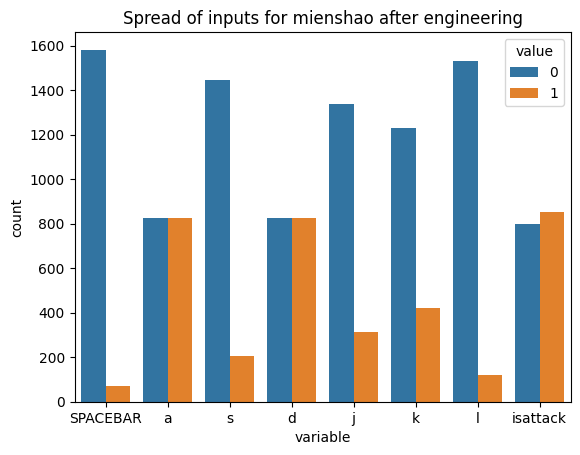

In [17]:
dropconf('mienshao')
bootstrap('mienshao', 'j')
bootstrap('mienshao', 'l', multiple=10)
dropnoatt('mienshao', 0.45)
flipall('mienshao')
sns.countplot(x="variable", hue="value", data=pd.melt(data_dict['mienshao']['inputs'])).set_title('Spread of inputs for {} after engineering'.format('mienshao'))

## 2.3 Modelling
___

Instead of using Keras/Tensoflow for our CNN model, we will be using Pytorch. Keras/Tensorflow has regrettably dropped support for GPU processing in 2023, thus we explore using Pytorch for the modelling to take advantage of GPU acceleration. 


The opponent Pokemon for which we want to model can be specified below.

In [18]:
# Assign the Pokemon opponent to be modelled on here:
pokemon = 'mienshao'

#### Tensors
In Pytorch, data is processed as [tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), a unique data structure for the input and outputs of a Pytorch model. Tensors  are similar to standard arrays and have unique functions in the Pytorch library, such as `.to()`, which allows us to run the tensor on a defined device, either a CPU or a GPU.

Below, we define our X (predictor) data as the `images` array data from `data_dict`. The y (target) data is defined as the row of columns in our `inputs` dataframe. The data is then converted to tensors.

In [19]:
# Assign image arrays as our X values, then convert the array to Pytorch tensor
X = np.float32(np.array([img/255.0 for img in data_dict[pokemon]['images']]))
X = torch.tensor(X).permute(0, 3, 1, 2)   # To permute array shape from NHWC to NCHW, necessary for PyTorch

# y features are encoded as binary vectors using np.array, then converted the array to Pytorch tensor
y = np.float32(np.array(data_dict[pokemon]['inputs']))
y = torch.tensor(y)

#### `CustomDataset` class
The `CustomDataset` class below is a child of the `Dataset` class native to the Pytorch library, and inherits all attributes from its parent class. We create this class to convert our data to an appropriate dataset object for our Pytorch model. This dataset object pairs each image with its corresponding input and is able to return both using appropriate functions.

In [20]:
class CustomDataset(Dataset):
    def __init__(self, imgs, label_df):
        # Initialization data
        self.labels = label_df
        self.images = imgs

    def __len__(self):
        # Return the size of the dataset
        return len(self.labels)

    def __getitem__(self, index):
        # Return a single data sample and its corresponding labels
        return (self.images[index], self.labels[index])

Using the `CustomDataset` class, we create our dataset object `fulldata`.

In [21]:
# Converting our data into a dataset compatible with Pytorch
fulldata = CustomDataset(X, y)

#### Training and validation data split
For typical neural network applications, the data is split into 3 portions: training, validation and testing. Training and validation data is seen by the model during the training process to iteratively minimise losses. Testing data meanwhile remains completely unseen by the model during training, and is used after training the model to test its performance on completely unseen data.

For our project however, we will prioritise the use of available data for only the training and validating process. Testing the model on unseen data will be done by deploying the model on the game itself, and assessing its performance in-game.

In [22]:
# Function to split our dataset object using Pytorch's random_split
def datasplit(data_in, split_ratio):
    trainlen = int(len(data_in) * split_ratio)
    train, test = random_split(data_in, [trainlen, len(data_in) - trainlen])
    print('Train length: {}'.format(trainlen))
    print('Test/validation length: {}'.format(len(test)))
    return train, test

In [23]:
# Splitting the data into the training set and the validation set
trainset, valset = datasplit(fulldata, 0.8)

Train length: 1321
Test/validation length: 331


#### Setting batch size
Here we define our batch size for the model. The batch size is applied to our dataset using the `Dataloader` function, which adds an additional 'batch' dimension to our data, with each batch comprising of 32 pairs of images and key inputs.

In [25]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

#### Building the CNN model


We now instantiate our CNN model object from the `CNN` class in `model_class.py`. This class is a child of the `nn.Module` class from the Pytorch library, and inherits all attributes from its parent class. The `CNN` class is defined in a seperate script as it is also used in our bot trial notebook and bot script.

The CNN structure is summarised below:

- **Input: image tensor**
- Convolution layer 1, filter size 3
    - RELU activation
        - Pooling layer
- Convolution layer 2, filter size 3
    - RELU activation
        - Pooling layer
- Convolution layer 3, filter size 3
    - RELU activation
        - Pooling layer
- [Batch normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) layer (commonly used in CNNs to improve training stability)
- Flattening layer
-  Linear layer 1
    - RELU activation
        - Applying [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) (randomly zeroes out a proportion of input tensors, to improve generalisability)
-  Linear layer 2
    - RELU activation
        - Applying dropout
-  Linear layer 3
    - RELU activation
        - Applying dropout
- Output layer
    - Sigmoid activation
- **Output: 8-value tensor (representing each input and `isattack`)**


Further details on the model architecture can be found in the `model_class.py` file.

In [42]:
from model_class import CNN

model = CNN()
model = model.to(device)

# Set totalepochs to 0 when instantiating the model object, which keeps track of the number of epochs.
totalepochs = 0

Here we assign the model optimiser as the Adam optimiser, which is popularly used for deep learning. The optimiser is assigned using the `optim` function from Pytorch. We also pass the parameters to optimise for our model, which are obtained from running the `parameters` function on our defined model. 

The relative small learning rate of 1e-6 was selected as higher learning rates resulted in a divergence between the training and validation loss at higher epochs. Using this learning rate allows the training and validation losses to intercept for our model.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)

We define the loss function for our model here, which is Binary Cross Entropy Loss, or [BCELoss](https://neptune.ai/blog/pytorch-loss-functions). BCELoss is commonly used for binary classifcation tasks, which is appropriate for our project.

In [ ]:
criterion = nn.BCELoss()

#### Defining functions for training and validation

The model training process in Pytorch can be customised based on the user's requirements and the application of the model. For our model, we will define two functions to performing the training and validation steps.

Both of these functions will perform predictions on the training/validation data respectively, allowing the model to iteratively update the model weights to minimise the respective losses. Note however that `model.train` is set to False for the validation function, and that the parameters are not updated or optimised using the `loss.backwards()` and `optimizer.step()` functions in the validation function.

The training and validation losses for each epoch are also appended to a list at the end of each epoch, allowing us to visualise the losses.

In [44]:
def train_one_epoch(model):
  model.train(True)

  running_loss = 0.0
  running_accuracy = 0.0
  # rn_att_recall = 0.0

  for index, data in enumerate(trainloader):
    inputs = data[0].to(device)
    labels = data[1].to(device)

    optimizer.zero_grad()

    outputs = model(inputs) 
    correct = torch.isclose(labels, outputs, atol=0.5).sum().item()
    running_accuracy += (correct/8) / (len(labels))

    # att_truepos = truepos(labels, outputs)
    # att_groundtrue = groundtrue(labels).item()
    # try:
    #   rn_att_recall += (att_truepos/3) / (att_groundtrue)
    # except:
    #   pass

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    
  avg_loss_across_batches = running_loss / len(trainloader)
  avg_acc_across_batches = (running_accuracy ) * 100 / len(trainloader)
  # avg_att_recall = rn_att_recall * 100 / len(trainloader)

  model.hloss_train.append(avg_loss_across_batches)
  model.hacc_train.append(avg_acc_across_batches)
  # model.hrec_train.append(avg_att_recall)

  print('Train loss: {0:.3f}, Accuracy: {1:.3f}%'.format(
                                                      avg_loss_across_batches,
                                                      avg_acc_across_batches))
                                                      # ,avg_att_recall))
  running_loss = 0.0
  running_accuracy = 0.0

  print()

In [45]:
def validate_one_epoch(model):
    model.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    # rn_att_recall = 0.0
    
    for index, data in enumerate(valloader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        with torch.no_grad():
            outputs = model(inputs) 
            correct = torch.isclose(labels, outputs, atol=0.5).sum().item()
            running_accuracy += (correct/8) / (len(labels))
    
            # att_truepos = truepos(labels, outputs)
            # att_groundtrue = groundtrue(labels).item()
            # try:
            #     rn_att_recall += (att_truepos/3) / (att_groundtrue)
            # except:
            #     pass
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    # avg_att_recall = rn_att_recall * 100 / len(valloader)

    model.hloss_val.append(avg_loss_across_batches)
    model.hacc_val.append(avg_acc_across_batches)
    # model.hrec_val.append(avg_att_recall)

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.3f}%'.format(
                                                      avg_loss_across_batches,
                                                      avg_acc_across_batches))
                                                    #   ,avg_att_recall))
    print('***************************************************\n')

#### Training the model
Finally, we train our model using the code block below. We can define the number of epochs to perform before running, giving us flexibility in defining the epochs to run. Repeated runs of the code block will perform additional epochs on the current model. Using this, we can iteratively throttle the number of epochs performed, to optimise the training and validation losses of the model.

In [56]:
num_epochs = 1
for epoch_index in range(num_epochs):
    print(f'Epoch: {totalepochs + epoch_index + 1}\n')
    
    train_one_epoch(model)
    validate_one_epoch(model)
        
totalepochs += num_epochs
print('Finished Training')

Epoch: 31

Train loss: 0.429, Accuracy: 81.148%

Val Loss: 0.428, Val Accuracy: 80.779%
***************************************************

Finished Training


#### Visualising the historic losses
Using the collected values for training and validation losses during training, we will visualise both losses on a shared line plot. Making reference to this line plot between epochs allows us to estimate how many further epochs to perform before we can achieve an interception of the 2 losses.

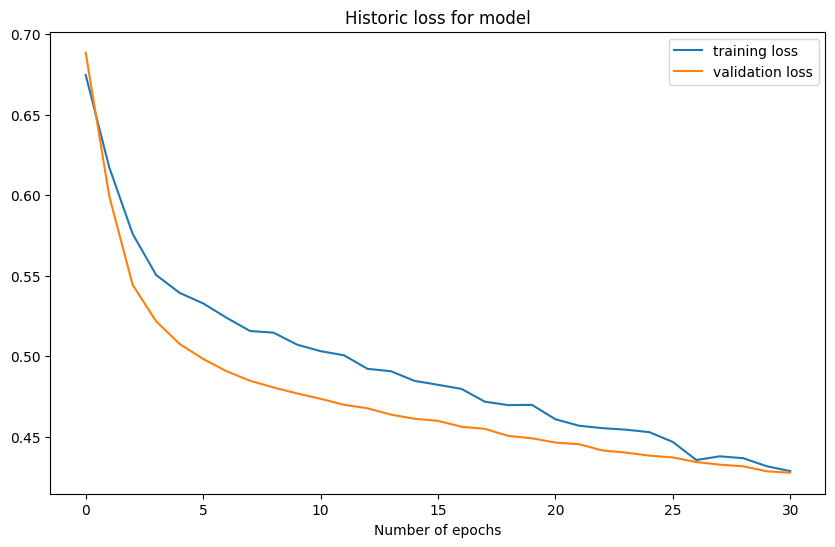

In [57]:
plt.figure(figsize=(10,6))
plt.plot(model.hloss_train, label='training loss')
plt.plot(model.hloss_val, label='validation loss')
plt.title('Historic loss for model')
plt.legend(loc='best')
plt.xlabel('Number of epochs')
plt.show()

#### Exporting the trained model

Once we are satisfied with the model losses, we can export the model using the Pytorch `torch.save` function below. We can then move on to performing trial runs for our bot.

In [58]:
torch.save(model.state_dict(), '../model/{}.pth'.format(pokemon))

### Deprecated
____

#### Tracking historic recall for the model

Before engineering the `isattack` feature for our `inputs` dataset, the functions below were used to keep track of the recall for attack keys over multiple epochs. However, this information was not useful for optimising attack recall as the recall value remained low over multiple epochs, due to the initially limited data engineering.

After engineering the `isattack` feature, this information is less relevant and has been commented out.

In [ ]:
# Function to sum up ground truth True value for attack keys ('j', 'k', 'l')
# def groundtrue(labels):
#     att_groundtrue = 0
#     for label in labels:
#         for y in label[4:]:
#             att_groundtrue += y
#     return (att_groundtrue)

# def truepos(labels, outputs):
#     att_truepos = 0
#     for label, output in zip(labels, outputs):
#         for x, y in zip(label[4:], output[4:]):
#             if torch.isclose(x, y, atol=0.5) and x:
#                 att_truepos += 1
#     return(att_truepos)

#### Using Tensorflow for modelling

In [ ]:
# def y_split(y):
#     result = []
#     for clm in list(y):
#         result.append(y[clm].to_numpy())
#     return result

In [ ]:
# inputs = Input(shape=imgshape)

# # Add a convolutional layer to the model. Then add pooling layer to follow convolutional layer.
# x = Conv2D(filters=20, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Add Conv2D and pooling layers, with 5x5 filter
# x = Conv2D(filters=20, kernel_size=(5, 5), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Add Conv2D and pooling layers, with 7x7 filter
# x = Conv2D(filters=20, kernel_size=(7, 7), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# # Flatten added after MaxPooling2D operates to flatten 2-D array into 1-D vector
# x = Flatten()(x)

# # Add 1 dense layer before output layers
# x = Dense(128, activation='relu')(x)

# # Add output layer for each of our 7 outputs.
# # Output layers use sigmoid activation, suitable for multi-label tasks when each output can be considered as an independent binary classification.
# output1 = Dense(1, activation='sigmoid', name='spacebar')(x)
# output2 = Dense(1, activation='sigmoid', name='a')(x)
# output3 = Dense(1, activation='sigmoid', name='s')(x)
# output4 = Dense(1, activation='sigmoid', name='d')(x)
# output5 = Dense(1, activation='sigmoid', name='j')(x)
# output6 = Dense(1, activation='sigmoid', name='k')(x)
# output7 = Dense(1, activation='sigmoid', name='l')(x)

# # Create model with above layers
# poliwrath_model = Model(inputs=inputs, outputs=[output1,output2,output3,output4,output5,output6,output7])

In [ ]:
# # Compile model
# # Binary cross-entropy loss function has been shown to work well with the sigmoid activation function
# opt = Adam(learning_rate=0.001) # create an optimizer using Adam with learning rate 1e-3
# poliwrath_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metric_dict)

In [ ]:
# history = poliwrath_model.fit(X_train, y_split(y_train), 
#                             batch_size=64,
#                             validation_data=(X_test, y_split(y_test)),
#                             epochs=15)

Epoch 1/15


5/5 [==============================] - 10s 2s/step - loss: 4.7420 - spacebar_loss: 0.8304 - a_loss: 1.3166 - s_loss: 0.6658 - d_loss: 0.6217 - j_loss: 0.5821 - k_loss: 0.4688 - l_loss: 0.2566 - spacebar_accuracy: 0.8836 - a_accuracy: 0.4945 - s_accuracy: 0.8691 - d_accuracy: 0.6655 - j_accuracy: 0.7782 - k_accuracy: 0.8436 - l_accuracy: 0.7673 - val_loss: 3.4475 - val_spacebar_loss: 0.4251 - val_a_loss: 0.7308 - val_s_loss: 0.4419 - val_d_loss: 0.6054 - val_j_loss: 0.5824 - val_k_loss: 0.5074 - val_l_loss: 0.1546 - val_spacebar_accuracy: 0.8696 - val_a_accuracy: 0.3623 - val_s_accuracy: 0.8841 - val_d_accuracy: 0.7101 - val_j_accuracy: 0.8551 - val_k_accuracy: 0.8116 - val_l_accuracy: 1.0000
Epoch 2/15
5/5 [==============================] - 7s 1s/step - loss: 3.0771 - spacebar_loss: 0.4258 - a_loss: 0.7217 - s_loss: 0.4931 - d_loss: 0.5445 - j_loss: 0.4496 - k_loss: 0.3881 - l_loss: 0.0543 - spacebar_accuracy: 0.8836 - a_accuracy: 0.4982 - s_accuracy: 0.8727 - d_accuracy: 

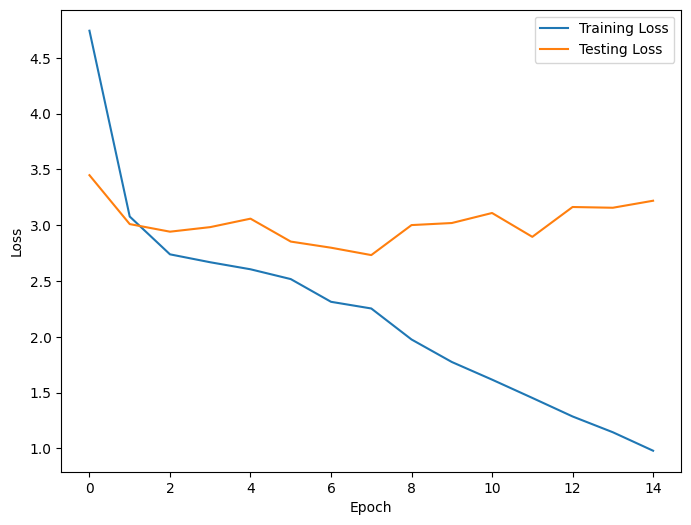

In [ ]:
# # Check out our train loss and test loss over epochs.
# train_loss = history.history['loss']
# test_loss = history.history['val_loss']

# # Set figure size.
# plt.figure(figsize=(8, 6))

# # Generate line plot of training, testing loss over epochs.
# plt.plot(train_loss, label='Training Loss')
# plt.plot(test_loss, label='Testing Loss')

# # Set title
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend();